In [1]:
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, roc_curve,auc
from catboost import Pool, CatBoostClassifier
from sklearn.metrics import accuracy_score

ModuleNotFoundError: No module named 'matplotlib'

In [2]:
# This cell loads all aggregated data fo all timestamps that are generated manually in vebt_agg_per_player_batch.py

dir_path = '/Users/omrilapidot/Vbet_adjusted_data/test/'

# Get all files in the directory
file_names = [f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))]

# Dictionary to hold dataframes
dfs = {}

for file_name in file_names:
    full_path = os.path.join(dir_path, file_name)
    try:
        with open(full_path, 'rb') as f:
            df = pickle.load(f)
            # If it is a dataframe, add to dictionary
            if hasattr(df, 'columns'):
                # Using filename without extension as the key
                key_name = os.path.splitext(file_name)[0]
                dfs[key_name] = df
    except Exception as e:
        # If there's an error in loading, it might not be a pickled dataframe
        print(f"Error loading {file_name}: {e}")


Error loading .DS_Store: invalid load key, '\x00'.


In [3]:
print(dfs.keys()) 

dict_keys(['final_combined_df_2_month_after_FTD', 'final_combined_df_1_month_after_FTD', 'final_combined_df_6_weeks_after_FTD', 'final_combined_df_FTD', 'final_combined_df_1_month_after_STD', 'final_combined_df_2_week_after_FTD', 'final_combined_df_after_STD'])


In [4]:
with open('/Users/omrilapidot/Vbet_adjusted_data/cube_finance_df.pkl', 'rb') as f:
    cube_finance_df = pickle.load(f)

In [5]:
cube_finance_df = cube_finance_df[["ClientId","TimestampHour","DepositAmountInEUR"]]


In [6]:
cube_finance_df

,ClientId,TimestampHour,DepositAmountInEUR
0,325024392,2022-09-08 08:00:00+00:00,NaN
1,403277511,2022-09-08 08:00:00+00:00,NaN
2,412425811,2022-09-08 08:00:00+00:00,NaN
3,685737277,2022-09-08 08:00:00+00:00,NaN
4,781492278,2022-09-08 17:00:00+00:00,NaN
...,...,...,...
818,232563960,2022-08-24 14:00:00+00:00,66.172939
819,652591765,2022-08-24 22:00:00+00:00,66.172939
820,577021996,2022-08-24 17:00:00+00:00,66.172939
821,555194674,2022-08-24 23:00:00+00:00,66.172939


In [7]:
# Same as in vebt_agg_per_player_batch - add ftd date and std date to finance table
cube_finance_df['FirstDepositDate'] = cube_finance_df.groupby('ClientId')['TimestampHour'].transform('min')
sorted_df = cube_finance_df.sort_values(by=['ClientId', 'TimestampHour'])
sorted_df= sorted_df.groupby('ClientId').nth(1)[["ClientId","TimestampHour"]].rename(columns = {"TimestampHour":"SecondTransactionDate"})
cube_finance_df = cube_finance_df.merge(sorted_df, on="ClientId", how="left")

In [8]:
# cube_finance_df

In [9]:
# t= sorted_df.groupby('ClientId').nth(1)[["ClientId","TimestampHour"]].rename(columns = {"TimestampHour":"SecondTransactionDate"})

In [10]:
# cube_finance_df = cube_finance_df.merge(t, on="ClientId", how="left")
# cube_finance_df['FirstDepositDate'] = cube_finance_df.groupby('ClientId')['TimestampHour'].transform('min')

In [11]:
def extract_time_frame_from_name(df_name):
    for time_frame in ['2_week', '1_month', '2_month', 'FTD',"6_week","STD"]:
        if time_frame in df_name:
            return time_frame
    return "Unknown"


def train_dataframe(df, df_name,save_figs = True):
    with open('/Users/omrilapidot/Vbet_adjusted_data/cube_finance_df.pkl', 'rb') as f:
        cube_finance_df = pickle.load(f)
    total_per_user = cube_finance_df.groupby('ClientId')['DepositAmountInEUR'].sum().reset_index()
    total_per_user.rename(columns={'DepositAmountInEUR': 'TotalDepositAmount'}, inplace=True)
    
    # Set time delta based on dataframe name
    num_of_week = None
    if "2_week" in df_name:
        num_of_week=2
        time_delta = pd.Timedelta(weeks=2)
    elif "1_month" in df_name:
        num_of_week = 4
        time_delta = pd.Timedelta(weeks=4)
    elif "2_month" in df_name:
        num_of_week = 8
        time_delta = pd.Timedelta(weeks=8)
    elif "6_weeks" in df_name:
        num_of_week = 6
        time_delta = pd.Timedelta(weeks=6)
    else:  # for FTD
        num_of_week = 0
        time_delta = pd.Timedelta(days=0)

        
    if "FTD" in df_name:
        ftd_of_std_transaction_date = "FirstDepositDate"
        bonus_name = "WeeksBetweenRegFTD"
            
    if "STD" in df_name:
        ftd_of_std_transaction_date = "SecondTransactionDate"
        bonus_name = "WeeksBetweenRegSTD"
    
    # Same as in vebt_agg_per_player_batch - add ftd date and std date to finance table

    cube_finance_df['FirstDepositDate'] = cube_finance_df.groupby('ClientId')['TimestampHour'].transform('min')
    sorted_df = cube_finance_df.sort_values(by=['ClientId', 'TimestampHour'])
    sorted_df= sorted_df.groupby('ClientId').nth(1)[["ClientId","TimestampHour"]].rename(columns = {"TimestampHour":"SecondTransactionDate"})
    cube_finance_df = cube_finance_df.merge(sorted_df, on="ClientId", how="left")

#     cube_finance_df['FirstDepositDate'] = cube_finance_df.groupby('ClientId')['TimestampHour'].transform('min')
    
    
    
    # Create labels and remove users that reached the HR threshold
    mask =  (cube_finance_df['TimestampHour'] < cube_finance_df[ftd_of_std_transaction_date] + time_delta)
    
    total_in_timeframe_per_user = cube_finance_df[mask].groupby('ClientId')['DepositAmountInEUR'].sum().reset_index()
    total_in_timeframe_per_user.rename(columns={'DepositAmountInEUR': f'{df_name}TotalDepositAmount'}, inplace=True)

    # Merge the results into one dataframe
    result_df = pd.merge(total_per_user, total_in_timeframe_per_user, on='ClientId', how='outer')

    percentile_95 = result_df['TotalDepositAmount'].quantile(0.95)
    print("percentile_95",percentile_95)
    result_df['label'] = result_df['TotalDepositAmount'] > percentile_95
    
    # create filter - For example std+4weeks_TotalDepositAmount > HR threshold. the second term (& result_df['label']) is just for validation
    mask = ~((result_df[f'{df_name}TotalDepositAmount'] > percentile_95) & result_df['label'])
    
    filtered_df = result_df[mask]

    # Assuming final_df is the dataframe you want to join with
    final_df = filtered_df[["ClientId", "label"]].merge(df, on="ClientId")
    
    # Add Bonus data manipulated by Omri
    #-------------------------------------------------------------------------------------------
    path = f"/Users/omrilapidot/Vbet_adjusted_data/test/BonusData/{num_of_week}_{bonus_name}.pkl"
    with open(path, 'rb') as f:
        bonus_df = pickle.load(f)
    final_df = final_df.merge(bonus_df , on="ClientId" , how="left")
    #-----------------------------------------------------------------------------------------------
    
    columns_to_drop = ['label', 'Id', 'SportsbookProfileId', 'IsVerified', 'VerificationDate', 'Created', 'Status',
                       'BirthDate', 'StatusName', 'Language', 'City']
    train_df, test_df = train_test_split(final_df, test_size=0.2, random_state=42)
    X_train = train_df.drop(columns_to_drop, axis=1)
    y_train = train_df['label']

    X_test = test_df.drop(columns_to_drop, axis=1)
    y_test = test_df['label']

    ClientId = X_test["ClientId"]
    X_train = X_train.drop("ClientId", axis=1)
    X_test = X_test.drop("ClientId", axis=1)

    
    # Identifying categorical features
    cat_features = X_train.select_dtypes(include=['object']).columns.tolist()

    # Fill NaN values in categorical columns with 'missing'
    for cat_col in cat_features:
        X_train[cat_col] = X_train[cat_col].fillna('missing')
        X_test[cat_col] = X_test[cat_col].fillna('missing')

    # Setting up data pools
    train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

    model = CatBoostClassifier(iterations=250, verbose=10)
    model.fit(train_pool, eval_set=test_pool)
    
    y_pred = model.predict(test_pool)
    y_pred = np.where(y_pred == 'True', True, False)
    y_prob = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
#     for t in range(0,100,1):
#         y_pred = y_prob>t/100
#         tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
#         tpr = tp / (tp + fn)
#         fpr = fp / (fp + tn)

#         print(f"Accuracy for {df_name}: ", accuracy)
#         print("Precision: ", precision_score(y_test, y_pred))
#         print("Recall: ", recall_score(y_test, y_pred))
# #         print("F1-Score: ", f1_score(y_test, y_pred))
#         print("True Positive Rate (TPR): ", tpr)
#         print("False Positive Rate (FPR): ", fpr)
#         print("*" * 100)

    output_folder = '/Users/omrilapidot/Desktop/plots'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Extract time frame from df_name
    time_frame = extract_time_frame_from_name(df_name)

    # Confusion Matrix Saving and Display
    if save_figs:
        plt.figure(figsize=(10,7))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=True)
        plt.title(f"Confusion Matrix for {time_frame}")
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.savefig(os.path.join(output_folder, f"Confusion_Matrix_{time_frame}.png"))
        plt.close()

        # Precision-Recall Curve Saving and Display
        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        plt.figure(figsize=(8, 6))
        plt.step(recall, precision, color='b', alpha=0.2, where='post')
        plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title(f'Precision-Recall Curve for {time_frame}')
        plt.savefig(os.path.join(output_folder, f"Precision_Recall_Curve_{time_frame}.png"))
        plt.close()
        
        
#    Feature Importances
#     importances = model.get_feature_importance()
#     columns = X_train.columns
#     sorted_features = sorted(zip(columns, importances), key=lambda x: x[1], reverse=True)
#     sorted_feature_dict = {k: v for k, v in sorted_features}
#     print(sorted_feature_dict)
    
    
#     return f1_score(y_test, y_pred),y_test.sum()
    return {"y_test":y_test,"y_prob":y_prob, "users":ClientId, "model":model}



# Loop over each dataframe and train
# sol = {}
# for key, dataframe in dfs.items():
#     sol[key] = train_dataframe(dataframe, key,save_figs = False)

In [12]:
def test_dataframe(df, df_name,model):
    with open('/Users/omrilapidot/Vbet_adjusted_data/cube_finance_df.pkl', 'rb') as f:
        cube_finance_df = pickle.load(f)
    total_per_user = cube_finance_df.groupby('ClientId')['DepositAmountInEUR'].sum().reset_index()
    total_per_user.rename(columns={'DepositAmountInEUR': 'TotalDepositAmount'}, inplace=True)
    
    # Set time delta based on dataframe name
    num_of_week = None
    if "2_week" in df_name:
        num_of_week=2
        time_delta = pd.Timedelta(weeks=2)
    elif "1_month" in df_name:
        num_of_week = 4
        time_delta = pd.Timedelta(weeks=4)
    elif "2_month" in df_name:
        num_of_week = 8
        time_delta = pd.Timedelta(weeks=8)
    elif "6_weeks" in df_name:
        num_of_week = 6
        time_delta = pd.Timedelta(weeks=6)
    else:  # for FTD
        num_of_week = 0
        time_delta = pd.Timedelta(days=0)

        
    if "FTD" in df_name:
        ftd_of_std_transaction_date = "FirstDepositDate"
        bonus_name = "WeeksBetweenRegFTD"
            
    if "STD" in df_name:
        ftd_of_std_transaction_date = "SecondTransactionDate"
        bonus_name = "WeeksBetweenRegSTD"
    

    cube_finance_df['FirstDepositDate'] = cube_finance_df.groupby('ClientId')['TimestampHour'].transform('min')
    sorted_df = cube_finance_df.sort_values(by=['ClientId', 'TimestampHour'])
    sorted_df= sorted_df.groupby('ClientId').nth(1)[["ClientId","TimestampHour"]].rename(columns = {"TimestampHour":"SecondTransactionDate"})
    cube_finance_df = cube_finance_df.merge(sorted_df, on="ClientId", how="left")

#     cube_finance_df['FirstDepositDate'] = cube_finance_df.groupby('ClientId')['TimestampHour'].transform('min')
    
    
    mask =  (cube_finance_df['TimestampHour'] < cube_finance_df[ftd_of_std_transaction_date] + time_delta)
    
    total_in_timeframe_per_user = cube_finance_df[mask].groupby('ClientId')['DepositAmountInEUR'].sum().reset_index()
    total_in_timeframe_per_user.rename(columns={'DepositAmountInEUR': f'{df_name}TotalDepositAmount'}, inplace=True)

    # Merge the results into one dataframe
    result_df = pd.merge(total_per_user, total_in_timeframe_per_user, on='ClientId', how='outer')

    percentile_95 = result_df['TotalDepositAmount'].quantile(0.95)
    print("percentile_95",percentile_95)
    result_df['label'] = result_df['TotalDepositAmount'] > percentile_95
    mask = ~((result_df[f'{df_name}TotalDepositAmount'] > percentile_95) & result_df['label'])
    filtered_df = result_df[mask]

    # Assuming final_df is the dataframe you want to join with
    final_df = filtered_df[["ClientId", "label"]].merge(df, on="ClientId")
    
    #-------------------------------------------------------------------------------------------
    path = f"/Users/omrilapidot/Vbet_adjusted_data/test/BonusData/{num_of_week}_{bonus_name}.pkl"
    with open(path, 'rb') as f:
        bonus_df = pickle.load(f)
    final_df = final_df.merge(bonus_df , on="ClientId" , how="left")
    #-----------------------------------------------------------------------------------------------
    
    columns_to_drop = ['label', 'Id', 'SportsbookProfileId', 'IsVerified', 'VerificationDate', 'Created', 'Status',
                       'BirthDate', 'StatusName', 'Language', 'City']


    X_test = final_df.drop(columns_to_drop, axis=1)
    ClientId = X_test["ClientId"]
    X_test = X_test.drop("ClientId", axis=1)

    

    cat_features = X_test.select_dtypes(include=['object']).columns.tolist()
    # Fill NaN values in categorical columns with 'missing'
    for cat_col in cat_features:
        X_test[cat_col] = X_test[cat_col].fillna('missing')

    
    y_pred = model.predict(X_test)
    y_pred = np.where(y_pred == 'True', True, False)
    y_prob = model.predict_proba(X_test)[:, 1]

    return {"y_prob":y_prob, "users":ClientId}

In [13]:
# path_to_file = '/Users/omrilapidot/Vbet_adjusted_data/model_sol_dict' # Change this path as needed
# with open(path_to_file, 'wb') as file:  # 'wb' is for write binary
#     pickle.dump(sol, file)

In [14]:
# output_folder = '/Users/omrilapidot/Desktop/plots'
# fig, axs = plt.subplots(len(dfs), 2, figsize=(20, len(dfs) * 10))

# for idx, key in enumerate(dfs):
#     time_frame = extract_time_frame_from_name(key)
    
#     # Checking if the image exists
#     cm_path = os.path.join(output_folder, f"Confusion_Matrix_{time_frame}.png")
#     prc_path = os.path.join(output_folder, f"Precision_Recall_Curve_{time_frame}.png")

#     if os.path.exists(cm_path) and os.path.exists(prc_path):
#         confusion_matrix_img = plt.imread(cm_path)
#         precision_recall_img = plt.imread(prc_path)
        
#         axs[idx, 0].imshow(confusion_matrix_img)
#         axs[idx, 0].axis('off')
#         axs[idx, 0].set_title(f"Confusion Matrix for {time_frame}")
        
#         axs[idx, 1].imshow(precision_recall_img)
#         axs[idx, 1].axis('off')
#         axs[idx, 1].set_title(f"Precision-Recall Curve for {time_frame}")
#     else:
#         print(f"Images for {time_frame} not found!")

# plt.tight_layout()
# plt.show()


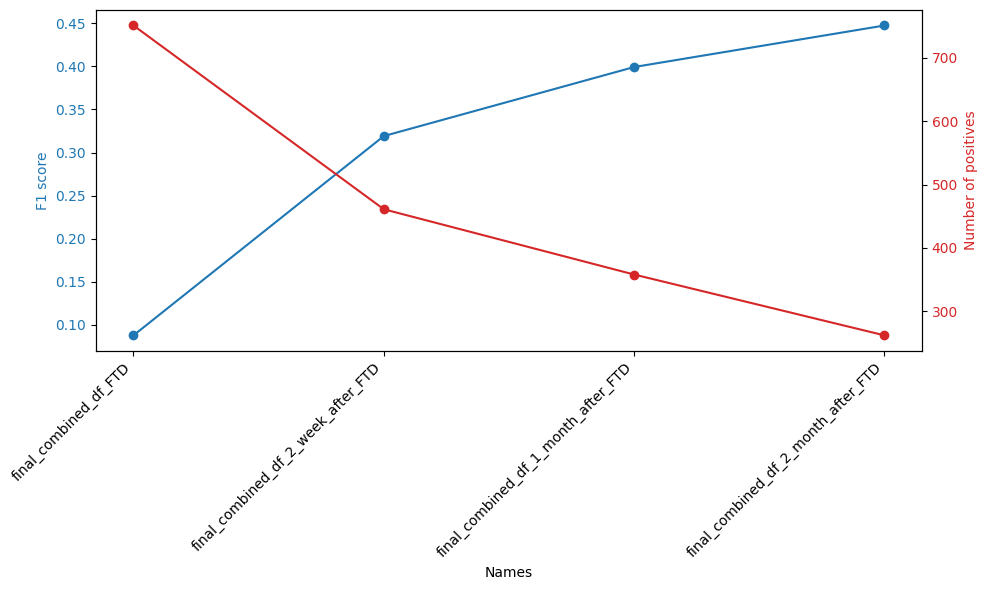

In [15]:
import matplotlib.pyplot as plt

# Your data
t = [["final_combined_df_FTD", 0.08782936010037641, 751],
     ["final_combined_df_2_week_after_FTD", 0.3190789473684211, 461],
     ["final_combined_df_1_month_after_FTD", 0.39919354838709675, 358],
     ["final_combined_df_2_month_after_FTD", 0.4473684210526316, 262]]

# Extract names, second values, and third values
names = [item[0] for item in t]
second_values = [item[1] for item in t]
third_values = [item[2] for item in t]

# Create a figure and a set of subplots (This returns a Figure and an Axes or array of Axes.)
fig, ax1 = plt.subplots(figsize=(10,6))

# Plotting the second values
color = 'tab:blue'
ax1.set_xlabel('Names')
ax1.set_ylabel('F1 score', color=color)
ax1.plot(names, second_values, color=color,marker='o')
ax1.tick_params(axis='y', labelcolor=color)

# Creating a secondary y-axis for third values
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Number of positives', color=color)
ax2.plot(names, third_values, color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

# Rotate x-axis labels for better readability
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha="right")

# Show the plot
plt.tight_layout()
plt.show()



In [16]:
# sol.keys()

In [98]:
time_frame = 'final_combined_df_after_STD'
y_test ,y_prob =  sol[time_frame]["y_test"],sol[time_frame]["y_prob"]

Precision:  0.192
True Positive Rate (TPR):  0.9174311926605505
False Positive Rate (FPR):  0.195766785548147


Text(0.5, 47.7222222222222, 'Predicted label')

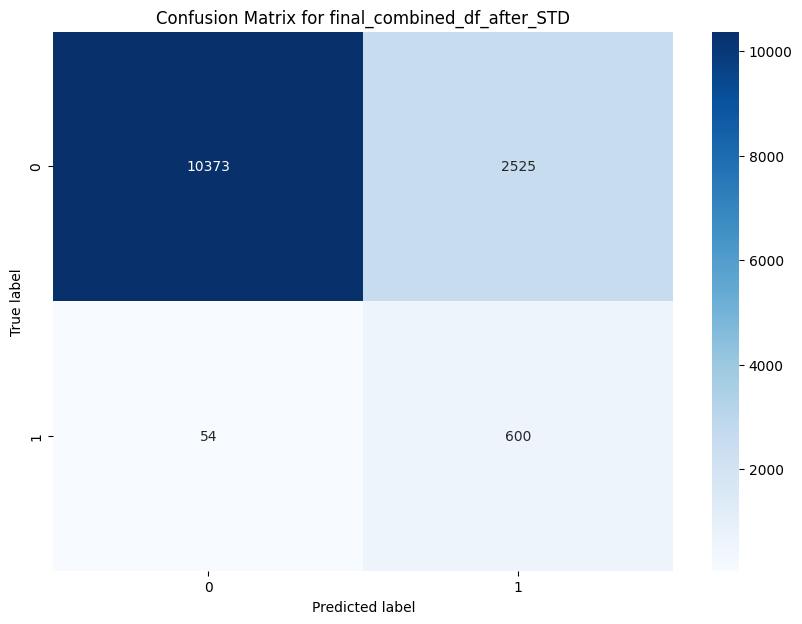

In [99]:
t=0.05
y_pred = y_prob>t
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tpr = tp / (tp + fn)
fpr = fp / (fp + tn)
# print(f"Accuracy for {time_frame}: ", accuracy)
print("Precision: ", precision_score(y_test, y_pred))
# print("Recall: ", recall_score(y_test, y_pred))
# print("F1-Score: ", f1_score(y_test, y_pred))
print("True Positive Rate (TPR): ", tpr)
print("False Positive Rate (FPR): ", fpr)

plt.figure(figsize=(10,7))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=True)
plt.title(f"Confusion Matrix for {time_frame}")
plt.ylabel('True label')
plt.xlabel('Predicted label')

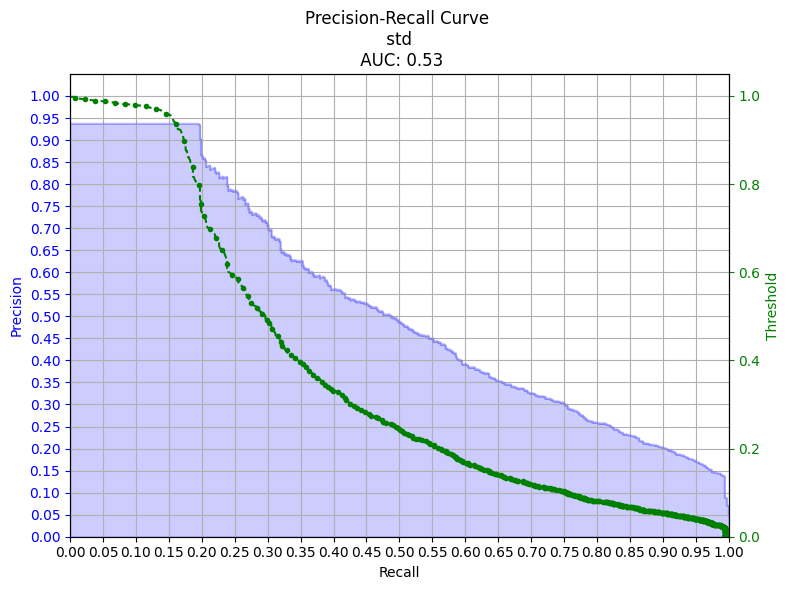

In [105]:

precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
precision = np.clip(precision, None, 0.937)
fig, ax1 = plt.figure(figsize=(8, 6)), plt.gca()
ax1.step(recall, precision, color='b', alpha=0.2, where='post')
ax1.set_ylim([0.0, 1.05])
ax1.set_xlim([0.5, 0.9])
ax1.fill_between(recall, precision, step='post', alpha=0.2, color='b')
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision', color='b')
ax1.tick_params('y', colors='b')

ax1.set_xticks(np.arange(0.0, 1.05, 0.05)) 
ax1.set_yticks(np.arange(0, 1.05, 0.05)) 
ax1.grid()

ax2 = ax1.twinx()
ax2.plot(recall[:-1], thresholds, color='g', linestyle='--', marker='o', markersize=3, markevery=10)
ax2.set_ylabel('Threshold', color='g')
ax2.tick_params('y', colors='g')
ax2.set_ylim([0, 1.05])

# plt.title(f'Precision-Recall Curve for {time_frame}')
plt.title(f'Precision-Recall Curve \n std \n AUC: {round(auc(recall, precision),2)}')
plt.tight_layout()
plt.show()



In [101]:
recall = np.clip(recall, None, 0.967)

In [102]:
clipped_values

array([0.95      , 0.95      , 0.95      , ..., 0.00578035, 0.00289017,
       0.        ])

In [22]:
def get_dataframe_for_element(element):
    dataframe_mapping = {
        'ftd': 'final_combined_df_FTD',
        'ftd + 2w': 'final_combined_df_2_week_after_FTD',
        'ftd + 4w': 'final_combined_df_1_month_after_FTD',
        'ftd + 6w': 'final_combined_df_6_weeks_after_FTD',
        'ftd + 8w': 'final_combined_df_2_month_after_FTD',
        'std': 'final_combined_df_after_STD',
        'std+4w': 'final_combined_df_1_month_after_STD'
    }

    if element in dataframe_mapping:
        return dataframe_mapping[element]
    else:
        return None


In [47]:
models_types = [
    'ftd',
    'ftd',
    'ftd + 2w',
    'ftd + 2w',
    'ftd + 4w',
    'ftd + 4w',
    'ftd + 6w',
    'ftd + 6w',
    'ftd + 8w',
    'ftd + 8w',
    'std',
    'std',
    'std+4w',
    'std+4w'
]
threshold = [0.05, 0.04, 0.35, 0.05, 0.61, 0.05, 0.57, 0.05, 0.4, 0.065, 0.45, 0.075, 0.65, 0.09]
result_dict = {
    'Model': [],
    'threshold': [],
    'Recall': [],
    'Precision': [],
    'False positive rate': [],
    'total_positive':[],
    "False Positives":[],
    "True Positives": [],
    "%of total high roller since FTD":[]
}

In [48]:
for models_type , t in zip(models_types,threshold):
    time_frame = get_dataframe_for_element(models_type)
    y_test ,y_prob =  sol[time_frame]["y_test"],sol[time_frame]["y_prob"]
    y_pred = y_prob>t
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    cm = confusion_matrix(y_test, y_pred)
    result_dict["Model"].append(models_type)
    result_dict["threshold"].append(t)
    result_dict["Recall"].append(round(recall_score(y_test, y_pred),3))
    result_dict["Precision"].append(round(precision_score(y_test, y_pred),3))
    result_dict["False positive rate"].append(round(fpr,3))
    result_dict["total_positive"].append(cm.sum(axis=1)[1])
    result_dict["False Positives"].append(fp)
    result_dict["True Positives"].append(tp)
    result_dict["%of total high roller since FTD"].append(cm.sum(axis=1)[1]/751)
#     result_dict["False positive rate"].append(fpr)
#     result_dict["False positive rate"].append(fpr)
#     result_dict["False positive rate"].append(fpr)
    
    
    
    
    
    
    
    
    
    # print(f"Accuracy for {time_frame}: ", accuracy)
#     print("Precision: ", precision_score(y_test, y_pred))
#     # print("Recall: ", recall_score(y_test, y_pred))
#     # print("F1-Score: ", f1_score(y_test, y_pred))
#     print("True Positive Rate (TPR): ", tpr)
#     print("False Positive Rate (FPR): ", fpr)

In [49]:
model_results = pd.DataFrame(result_dict)

In [50]:
# path_to_file = '/Users/omrilapidot/Vbet_adjusted_data/model_results' # Change this path as needed
# with open(path_to_file, 'wb') as file:  # 'wb' is for write binary
#     pickle.dump(model_results, file)

In [51]:
model_results

,Model,threshold,Recall,Precision,False positive rate,total_positive,False Positives,True Positives,%of total high roller since FTD
0,ftd,0.050,0.473,0.118,0.207,751,2657,355,1.000000
1,ftd,0.040,0.742,0.080,0.501,751,6430,557,1.000000
2,ftd + 2w,0.350,0.293,0.570,0.008,461,102,135,0.613848
3,ftd + 2w,0.050,0.681,0.214,0.089,461,1150,314,0.613848
4,ftd + 4w,0.610,0.251,0.804,0.002,358,22,90,0.476698
5,ftd + 4w,0.050,0.698,0.225,0.067,358,862,250,0.476698
6,ftd + 6w,0.570,0.351,0.806,0.002,285,24,100,0.379494
7,ftd + 6w,0.050,0.702,0.284,0.039,285,503,200,0.379494
8,ftd + 8w,0.400,0.363,0.674,0.004,262,46,95,0.348868
9,ftd + 8w,0.065,0.668,0.288,0.034,262,432,175,0.348868


In [ ]:
# # # # # #

In [ ]:
# Until Here - Model training and standard evaluation

# From here - The Denys task - wet experiment on unseen users with all relevant manipulation

In [ ]:
# # # # # # # 

In [17]:
ClientId_to_test = pd.read_csv('/Users/omrilapidot/Downloads/Validation data. Model Focus Players. std+4w.csv')  

In [18]:
ClientId_to_test

,ClientId
0,118416113
1,146830912
2,165498421
3,178746731
4,186023749
...,...
1892,1442292138
1893,1442425895
1894,1442426588
1895,1442528251


In [19]:
with open('/Users/omrilapidot/Vbet_adjusted_data/dates1_df.pkl', 'rb') as f:
    dates1_df = pickle.load(f)

In [20]:
dates1_df

,ClientId,RegDate,FirstDepositDate,SecondTransactionDate,daysBetweenRegFTD,daysBetweenRegSTD
0,380211768,2021-05-08,2021-05-08 16:00:00,2021-05-12 15:00:00,0,4
13,583591209,2022-02-24,2022-02-25 10:00:00,2022-02-25 12:00:00,1,1
26,829610428,2022-09-09,2022-09-10 02:00:00,2022-09-10 07:00:00,1,1
39,441074097,2021-08-27,2021-08-27 11:00:00,NaT,0,1000
52,702002326,2022-06-05,2022-06-05 17:00:00,2022-06-05 19:00:00,0,0
...,...,...,...,...,...,...
723879,439184098,2021-08-24,2021-08-24 20:00:00,NaT,0,1000
723892,554164913,2022-01-22,2022-01-22 17:00:00,NaT,0,1000
723905,344490420,2021-03-07,2021-03-07 17:00:00,2021-03-09 14:00:00,0,2
723918,510501516,2021-11-27,2021-11-27 14:00:00,2021-12-01 02:00:00,0,4


In [21]:
dfs.keys()

dict_keys(['final_combined_df_2_month_after_FTD', 'final_combined_df_1_month_after_FTD', 'final_combined_df_6_weeks_after_FTD', 'final_combined_df_FTD', 'final_combined_df_1_month_after_STD', 'final_combined_df_2_week_after_FTD', 'final_combined_df_after_STD'])

In [22]:
dfs["final_combined_df_1_month_after_STD"].merge(ClientId_to_test , on="ClientId")

,Id,PartnerId,CurrencyId,Language,IsLocked,IsTest,IsVerified,ClientGender,BirthDate,Age,...,BonusAmountInEurSB_sum_2_month_y,BonusAmountInEurSB_count_2_month_y,BonusBetAmount_sum_2_month_y,BonusBetAmount_count_2_month_y,BonusBetAmountInEurSB_sum_2_month_y,BonusBetAmountInEurSB_count_2_month_y,RealBetAmount_sum_2_month_y,RealBetAmount_count_2_month_y,RealBetAmountInEurSB_sum_2_month_y,RealBetAmountInEurSB_count_2_month_y
0,1385862856,692,BRL,PB,False,False,True,Male,1998-06-16,25.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1398934588,692,BRL,PB,False,False,False,Male,1971-05-05,52.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1395198068,692,BRL,PB,True,False,True,Male,1990-10-10,33.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1350959246,692,BRL,PB,False,False,False,Female,1996-07-20,27.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,847923456,692,BRL,PB,False,False,False,Male,1989-11-14,34.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1889,1349659799,692,BRL,PB,False,False,True,Female,1981-11-04,42.0,...,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0
1890,564391330,692,USD,PB,False,False,True,Male,1995-06-01,28.0,...,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0
1891,1392738267,692,PEN,ES,False,False,True,Female,1992-01-06,31.0,...,0.0,30.0,0.0,30.0,0.0,30.0,0.0,30.0,0.0,30.0
1892,1424704116,692,BRL,PB,False,False,True,Female,1986-03-15,37.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
# cube_finance_df["TimestampHour"].max()

In [23]:
dates1_df

,ClientId,RegDate,FirstDepositDate,SecondTransactionDate,daysBetweenRegFTD,daysBetweenRegSTD
0,380211768,2021-05-08,2021-05-08 16:00:00,2021-05-12 15:00:00,0,4
13,583591209,2022-02-24,2022-02-25 10:00:00,2022-02-25 12:00:00,1,1
26,829610428,2022-09-09,2022-09-10 02:00:00,2022-09-10 07:00:00,1,1
39,441074097,2021-08-27,2021-08-27 11:00:00,NaT,0,1000
52,702002326,2022-06-05,2022-06-05 17:00:00,2022-06-05 19:00:00,0,0
...,...,...,...,...,...,...
723879,439184098,2021-08-24,2021-08-24 20:00:00,NaT,0,1000
723892,554164913,2022-01-22,2022-01-22 17:00:00,NaT,0,1000
723905,344490420,2021-03-07,2021-03-07 17:00:00,2021-03-09 14:00:00,0,2
723918,510501516,2021-11-27,2021-11-27 14:00:00,2021-12-01 02:00:00,0,4


In [46]:
# ClientId_to_test = ClientId_to_test.merge(dates1_df,on="ClientId")

In [25]:
dates2_df = cube_finance_df.drop_duplicates("ClientId")

In [26]:
ClientId_to_test = ClientId_to_test.merge(dates2_df,on="ClientId")

In [27]:
ClientId_to_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1894 entries, 0 to 1893
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   ClientId               1894 non-null   int64              
 1   TimestampHour          1894 non-null   datetime64[ns, UTC]
 2   DepositAmountInEUR     1615 non-null   float64            
 3   FirstDepositDate       1894 non-null   datetime64[ns, UTC]
 4   SecondTransactionDate  1857 non-null   datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](3), float64(1), int64(1)
memory usage: 74.1 KB


In [30]:


# Assuming 'df' is your DataFrame
# Ensure that the 'SecondTransactionDate' is in datetime format (if it's not already)
ClientId_to_test['SecondTransactionDate'] = pd.to_datetime(ClientId_to_test['SecondTransactionDate'])

# Create a boolean mask for the rows where 'SecondTransactionDate' is June 23, 2023
mask = (
    (ClientId_to_test['SecondTransactionDate'].dt.year == 2023) &
    (ClientId_to_test['SecondTransactionDate'].dt.month >= 5) & 
    (ClientId_to_test['SecondTransactionDate'].dt.month < 7)
)

# Apply the mask to filter your DataFrame
filtered_df = ClientId_to_test.loc[mask]

# 'filtered_df' will now contain only rows where 'SecondTransactionDate' is June 23, 2023.

#--------------------------to delete--------------------------------
filtered_df = ClientId_to_test

In [31]:
filtered_df

,ClientId,TimestampHour,DepositAmountInEUR,FirstDepositDate,SecondTransactionDate
0,178746731,2021-06-03 04:00:00+00:00,1.257941,2021-06-03 04:00:00+00:00,2023-05-29 23:00:00+00:00
1,186023749,2023-07-10 00:00:00+00:00,0.000000,2020-01-20 00:00:00+00:00,2023-03-17 01:00:00+00:00
2,199476778,2021-12-03 09:00:00+00:00,7.831868,2021-12-03 09:00:00+00:00,2023-05-01 15:00:00+00:00
3,203004607,2021-09-29 18:00:00+00:00,2.636568,2021-07-31 03:00:00+00:00,2021-07-31 13:00:00+00:00
4,229156953,2023-05-15 01:00:00+00:00,0.000000,2020-06-04 11:00:00+00:00,2023-05-08 13:00:00+00:00
...,...,...,...,...,...
1889,1442292138,2023-06-03 14:00:00+00:00,0.000000,2023-06-03 13:00:00+00:00,2023-06-03 14:00:00+00:00
1890,1442425895,2023-06-03 14:00:00+00:00,8.178696,2023-06-03 14:00:00+00:00,2023-06-03 15:00:00+00:00
1891,1442426588,2023-06-03 14:00:00+00:00,2.726232,2023-06-03 14:00:00+00:00,2023-06-03 16:00:00+00:00
1892,1442528251,2023-06-03 16:00:00+00:00,0.000000,2023-06-03 15:00:00+00:00,2023-06-03 16:00:00+00:00


In [32]:
key = "final_combined_df_1_month_after_STD"

In [33]:
dataframe = dfs[key]

In [34]:
dataframe_train = dataframe[~dataframe["Id"].isin(filtered_df.ClientId)]
dataframe_test = dataframe[dataframe["Id"].isin(filtered_df.ClientId)]

In [35]:
dataframe

,Id,PartnerId,CurrencyId,Language,IsLocked,IsTest,IsVerified,ClientGender,BirthDate,Age,...,BonusAmountInEurSB_sum_2_month_y,BonusAmountInEurSB_count_2_month_y,BonusBetAmount_sum_2_month_y,BonusBetAmount_count_2_month_y,BonusBetAmountInEurSB_sum_2_month_y,BonusBetAmountInEurSB_count_2_month_y,RealBetAmount_sum_2_month_y,RealBetAmount_count_2_month_y,RealBetAmountInEurSB_sum_2_month_y,RealBetAmountInEurSB_count_2_month_y
15,475096324,692,BRL,PB,False,False,False,Female,1967-08-18,56.0,...,0.000000,38.0,0.0,38.0,0.0,38.0,0.0,38.0,0.0,38.0
16,1065829568,692,BRL,PB,False,False,True,Female,1973-04-01,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,293026305,692,BRL,EN,False,False,False,Male,1971-07-16,52.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,1440543393,692,USD,PB,False,False,True,Male,1970-03-31,53.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,401878765,692,USD,EN,False,False,False,Male,1966-05-04,57.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407163,615635659,692,BRL,PB,False,False,False,Male,1986-08-13,37.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
407171,404600097,692,BRL,EN,False,False,False,Male,2003-04-20,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
407175,339359008,692,BRL,PB,False,False,False,Male,2002-07-08,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
407176,1460092277,692,BRL,PB,False,False,False,Male,2005-05-30,18.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
std_4_week_dict = train_dataframe(dataframe_train, key,save_figs = False)

percentile_95 567.3846560880006
Learning rate set to 0.153254
0:	learn: 0.4260179	test: 0.4248404	best: 0.4248404 (0)	total: 257ms	remaining: 1m 4s
10:	learn: 0.0713559	test: 0.0722020	best: 0.0722020 (10)	total: 1.79s	remaining: 38.8s
20:	learn: 0.0625517	test: 0.0650911	best: 0.0650911 (20)	total: 3.33s	remaining: 36.3s
30:	learn: 0.0599633	test: 0.0639584	best: 0.0639584 (30)	total: 4.88s	remaining: 34.5s
40:	learn: 0.0582591	test: 0.0638162	best: 0.0638162 (40)	total: 6.27s	remaining: 32s
50:	learn: 0.0568331	test: 0.0637187	best: 0.0636815 (49)	total: 7.72s	remaining: 30.1s
60:	learn: 0.0558192	test: 0.0636661	best: 0.0635744 (57)	total: 9.23s	remaining: 28.6s
70:	learn: 0.0548328	test: 0.0637253	best: 0.0635744 (57)	total: 10.6s	remaining: 26.8s
80:	learn: 0.0538341	test: 0.0639530	best: 0.0635744 (57)	total: 12.1s	remaining: 25.1s
90:	learn: 0.0520788	test: 0.0636754	best: 0.0635744 (57)	total: 13.5s	remaining: 23.7s
100:	learn: 0.0509741	test: 0.0634949	best: 0.0634627 (98)	tot

In [64]:
dataframe_test

,Id,PartnerId,CurrencyId,Language,IsLocked,IsTest,IsVerified,ClientGender,BirthDate,Age,...,BonusAmountInEurSB_sum_2_month_y,BonusAmountInEurSB_count_2_month_y,BonusBetAmount_sum_2_month_y,BonusBetAmount_count_2_month_y,BonusBetAmountInEurSB_sum_2_month_y,BonusBetAmountInEurSB_count_2_month_y,RealBetAmount_sum_2_month_y,RealBetAmount_count_2_month_y,RealBetAmountInEurSB_sum_2_month_y,RealBetAmountInEurSB_count_2_month_y
56,1385862856,692,BRL,PB,False,False,True,Male,1998-06-16,25.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
831,1398934588,692,BRL,PB,False,False,False,Male,1971-05-05,52.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1056,1395198068,692,BRL,PB,True,False,True,Male,1990-10-10,33.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1067,1350959246,692,BRL,PB,False,False,False,Female,1996-07-20,27.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1136,847923456,692,BRL,PB,False,False,False,Male,1989-11-14,34.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406428,1349659799,692,BRL,PB,False,False,True,Female,1981-11-04,42.0,...,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0,0.0,9.0
406456,564391330,692,USD,PB,False,False,True,Male,1995-06-01,28.0,...,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0,0.0,2.0
406536,1392738267,692,PEN,ES,False,False,True,Female,1992-01-06,31.0,...,0.0,30.0,0.0,30.0,0.0,30.0,0.0,30.0,0.0,30.0
406569,1424704116,692,BRL,PB,False,False,True,Female,1986-03-15,37.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [133]:
std_4_week_dict_test = test_dataframe(dataframe_test, key,std_4_week_dict["model"])

percentile_95 567.3846560880006


In [134]:
std_4_week_dict_test.keys()

dict_keys(['y_prob', 'users'])

In [135]:
pred_df = pd.DataFrame(std_4_week_dict_test)

In [146]:
pred_df["pred"] = pred_df["y_prob"]>0.25

In [147]:
pred_df["pred"].sum()

49

In [148]:
pred_df

,y_prob,users,pred
0,0.008539,178746731,False
1,0.011722,186023749,False
2,0.002494,199476778,False
3,0.068001,203004607,False
4,0.019366,229156953,False
...,...,...,...
1889,0.006728,1442292138,False
1890,0.003774,1442425895,False
1891,0.003704,1442426588,False
1892,0.013451,1442528251,False


In [149]:
cube_finance_df.groupby("ClientId")["DepositAmountInEUR"].sum().reset_index()

,ClientId,DepositAmountInEUR
0,177054004,195.686456
1,177064942,21.524354
2,177065994,10.762177
3,177071940,21.524354
4,177072299,0.000000
...,...,...
70420,1597106625,1.916962
70421,1597288970,1.916962
70422,1597363134,5.750886
70423,1597366753,5.750886


In [150]:
pred_df = pred_df.merge(cube_finance_df.groupby("ClientId")["DepositAmountInEUR"].sum().reset_index(), left_on="users",right_on="ClientId")

In [151]:
# pred_df[pred_df["pred"]]

In [152]:
cube_finance_df["befor_prediction"] = cube_finance_df["TimestampHour"] < cube_finance_df["SecondTransactionDate"] + pd.DateOffset(weeks=4)

In [153]:
t = cube_finance_df[cube_finance_df["befor_prediction"]].groupby("ClientId")["DepositAmountInEUR"].sum().reset_index()

In [154]:
t.rename(columns={"DepositAmountInEUR":"DepositAmountInEUR_befor_predictin"}, inplace=True)

In [155]:
t

,ClientId,DepositAmountInEUR_befor_predictin
0,177054004,195.686456
1,177089617,65.225897
2,177116139,16.154310
3,177203709,78.283987
4,177210844,322.865310
...,...,...
38088,1595487504,1.209709
38089,1595555319,19.043100
38090,1595690485,0.000000
38091,1595740623,3.833924


In [156]:
pred_df = pred_df.merge(t, left_on="users",right_on="ClientId")

In [157]:
additional_users = pred_df[(pred_df["DepositAmountInEUR"]>500) & (pred_df["DepositAmountInEUR_befor_predictin"]<250)& (pred_df["DepositAmountInEUR_befor_predictin"]>100)].ClientId_x.tolist()

In [158]:
pred_df[pred_df["pred"]]

,y_prob,users,pred,ClientId_x,DepositAmountInEUR,ClientId_y,DepositAmountInEUR_befor_predictin
8,0.312781,269435179,True,269435179,518.477596,269435179,28.506244
18,0.269321,354544786,True,354544786,548.489445,354544786,134.421861
22,0.653562,374117069,True,374117069,487.255163,374117069,318.277181
40,0.659553,475974547,True,475974547,293.138586,475974547,145.791394
46,0.855991,496218286,True,496218286,394.771856,496218286,182.568754
47,0.690803,499131681,True,499131681,383.359639,499131681,348.808016
80,0.286190,611160391,True,611160391,252.312347,611160391,184.888683
87,0.770496,627583993,True,627583993,210.036442,627583993,144.357465
153,0.382164,828328881,True,828328881,298.968145,828328881,200.955345
156,0.317322,834021240,True,834021240,84.728402,834021240,66.625942


In [159]:
pred_df[pred_df["DepositAmountInEUR"]>567]

,y_prob,users,pred,ClientId_x,DepositAmountInEUR,ClientId_y,DepositAmountInEUR_befor_predictin
1,0.011722,186023749,False,186023749,660.950914,186023749,282.319392
15,0.011334,330878607,False,330878607,650.822884,330878607,24.867619
21,0.012204,373292262,False,373292262,845.157838,373292262,15.117387
33,0.078931,421784190,False,421784190,639.679037,421784190,24.244392
36,0.011085,437297479,False,437297479,964.236741,437297479,15.160268
48,0.133066,509450146,False,509450146,1171.998820,509450146,67.294810
67,0.160734,568136906,False,568136906,607.472245,568136906,85.782650
89,0.022984,630021680,False,630021680,728.244926,630021680,28.591034
95,0.006215,659542258,False,659542258,622.726006,659542258,33.746246
111,0.029312,738235958,False,738235958,952.659754,738235958,11.228723


In [160]:
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1857 entries, 0 to 1856
Data columns (total 7 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   y_prob                              1857 non-null   float64
 1   users                               1857 non-null   int64  
 2   pred                                1857 non-null   bool   
 3   ClientId_x                          1857 non-null   int64  
 4   DepositAmountInEUR                  1857 non-null   float64
 5   ClientId_y                          1857 non-null   int64  
 6   DepositAmountInEUR_befor_predictin  1857 non-null   float64
dtypes: bool(1), float64(3), int64(3)
memory usage: 89.0 KB


In [111]:
# Assume pred_df is your DataFrame

# List of ClientId_x values that you want to update
# numbers = 

client_ids_to_update =[
    1331303051,
    1377420606,
    1390579138,
    1390746790,
    1408292981,
    1409653965,
    1412998534,
    1413385654,
    1416158521,
    1422699117,
    1425418616,
    1427931434,
    1432535443
]+ additional_users
# [1413385654, 1390579138]

# Using .loc to update 'pred' where the condition is met
for client_id in client_ids_to_update:
    pred_df.loc[pred_df['ClientId_x'] == client_id, 'pred'] = True




In [161]:
pred_df[pred_df["pred"]]

,y_prob,users,pred,ClientId_x,DepositAmountInEUR,ClientId_y,DepositAmountInEUR_befor_predictin
8,0.312781,269435179,True,269435179,518.477596,269435179,28.506244
18,0.269321,354544786,True,354544786,548.489445,354544786,134.421861
22,0.653562,374117069,True,374117069,487.255163,374117069,318.277181
40,0.659553,475974547,True,475974547,293.138586,475974547,145.791394
46,0.855991,496218286,True,496218286,394.771856,496218286,182.568754
47,0.690803,499131681,True,499131681,383.359639,499131681,348.808016
80,0.286190,611160391,True,611160391,252.312347,611160391,184.888683
87,0.770496,627583993,True,627583993,210.036442,627583993,144.357465
153,0.382164,828328881,True,828328881,298.968145,828328881,200.955345
156,0.317322,834021240,True,834021240,84.728402,834021240,66.625942


In [113]:
pred_df[pred_df["DepositAmountInEUR"]>567]

,y_prob,users,pred,ClientId_x,DepositAmountInEUR,ClientId_y,DepositAmountInEUR_befor_predictin
1,0.011722,186023749,False,186023749,660.950914,186023749,282.319392
15,0.011334,330878607,False,330878607,650.822884,330878607,24.867619
21,0.012204,373292262,False,373292262,845.157838,373292262,15.117387
33,0.078931,421784190,False,421784190,639.679037,421784190,24.244392
36,0.011085,437297479,False,437297479,964.236741,437297479,15.160268
48,0.133066,509450146,False,509450146,1171.998820,509450146,67.294810
67,0.160734,568136906,False,568136906,607.472245,568136906,85.782650
89,0.022984,630021680,False,630021680,728.244926,630021680,28.591034
95,0.006215,659542258,False,659542258,622.726006,659542258,33.746246
111,0.029312,738235958,False,738235958,952.659754,738235958,11.228723


In [123]:
pred_df = pred_df[["ClientId_x","pred","DepositAmountInEUR_befor_predictin"]]

In [124]:
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1857 entries, 0 to 1856
Data columns (total 3 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   ClientId_x                          1857 non-null   int64  
 1   pred                                1857 non-null   bool   
 2   DepositAmountInEUR_befor_predictin  1857 non-null   float64
dtypes: bool(1), float64(1), int64(1)
memory usage: 31.0 KB


In [125]:
# pred_df[pred_df["pred"]]

In [126]:
import pandas as pd

# Your DataFrame is pred_df

# Renaming the columns
pred_df = pred_df.rename(columns={
    'ClientId_x': 'ClientId',  # removing _x
    'DepositAmountInEUR_befor_predictin': 'DepositAmountInEURAtPredictionTime',  # renaming for clarity
    'pred': 'Prediction'  # changing 'pred' to 'Prediction'
})

# Now, let's check the first few rows of the dataframe to see the changes
print(pred_df.head())




    ClientId  Prediction  DepositAmountInEURAtPredictionTime
0  178746731       False                            3.075429
1  186023749       False                          282.319392
2  199476778       False                            9.645744
3  203004607       False                           31.013434
4  229156953       False                          211.033420


In [130]:
pred_df[pred_df["Prediction"]]

,ClientId,Prediction,DepositAmountInEURAtPredictionTime
18,354544786,True,134.421861
22,374117069,True,318.277181
40,475974547,True,145.791394
46,496218286,True,182.568754
47,499131681,True,348.808016
87,627583993,True,144.357465
183,892548642,True,259.478975
320,1240848568,True,145.830068
355,1275005981,True,135.814399
440,1311070997,True,233.353456


In [132]:
pred_df

,ClientId,Prediction,DepositAmountInEURAtPredictionTime
0,178746731,False,3.075429
1,186023749,False,282.319392
2,199476778,False,9.645744
3,203004607,False,31.013434
4,229156953,False,211.033420
...,...,...,...
1852,1442292138,False,31.260792
1853,1442425895,False,17.271302
1854,1442426588,False,4.543720
1855,1442528251,False,74.517004


In [131]:
pred_df.to_csv('/Users/omrilapidot/Vbet_final_risolt/Prediction_On_Validation_data_01.csv', index=False)

In [61]:
# cube_finance_df.drop_duplicates("ClientId")